In [1]:
from fastai.tabular.all import *

In [2]:
df = pd.read_csv('ncaa_detailed_scores.csv', index_col=0)

In [3]:
df.head()

,date,home_team,home_score,away_team,away_score,diff,season,is_tournament,home_score_at_home,home_defense_at_home,away_score_at_away,away_defense_at_away,home_score_total,home_defense_total,away_score_total,away_defense_total,conference_home,conference_away,home_recovery,away_recovery
0,2015-11-13,Hawaii,87,Montana State,76,11,15/16,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Big West,Big Sky,255.0,255.0
1,2015-11-13,Eastern Michigan,70,Vermont,50,20,15/16,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Mid-American,America East,255.0,255.0
2,2015-11-13,Columbia,107,Kean,62,45,15/16,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Ivy League,NaN,255.0,255.0
3,2015-11-13,Louisiana-Monroe,88,McMurry,43,45,15/16,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sun Belt,NaN,255.0,255.0
4,2015-11-13,Yale,70,Fairfield,57,13,15/16,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Ivy League,Metro Atlantic Athletic,255.0,255.0


In [4]:
cat_columns = ['home_team', 'away_team', 'conference_home', 'conference_away', 'season', 'is_tournament']
drop_columns = ['date', 'home_score', 'away_score']
dep_column = 'diff'

cont_columns = [c for c in df.columns if c not in cat_columns + drop_columns + [dep_column]]

#df = df[cat_columns + cont_columns + [dep_column]]

In [5]:
splits = RandomSplitter(valid_pct = 0.2)(range_of(df))

In [6]:
to = TabularPandas(
    df,
    procs = [Categorify, FillMissing, Normalize],
    cat_names = cat_columns,
    cont_names = cont_columns,
    y_names = dep_column,
    splits = splits
)

In [7]:
dls = to.dataloaders(bs = 64)

In [8]:
dls.show_batch()

,home_team,away_team,conference_home,conference_away,season,is_tournament,home_score_at_home,home_defense_at_home,away_score_at_away,away_defense_at_away,home_score_total,home_defense_total,away_score_total,away_defense_total,home_recovery,away_recovery,diff
0,Florida International,Southern Miss,Conference USA,Conference USA,17/18,False,7.173333e+01,69.666664,61.200001,77.699997,70.681816,70.045456,72.772728,72.909088,5.0,5.000001,6.0
1,Eastern Kentucky,Tennessee State,Ohio Valley,Ohio Valley,15/16,False,8.735714e+01,78.428573,74.181816,71.727272,80.851852,79.333336,74.333336,68.666664,2.0,3.000001,-1.0
2,Southern Utah,Northern Arizona,Big Sky,Big Sky,17/18,False,8.300000e+01,79.571427,61.299999,77.500000,78.866669,86.266671,65.133331,78.266670,7.0,7.000000,6.0
3,American University,Colgate,Patriot League,Patriot League,18/19,False,7.425000e+01,66.333336,71.625000,71.437500,71.958336,68.541664,73.730766,69.884613,3.0,3.000001,-2.0
4,UAB,Alabama State,Conference USA,Southwestern Athletic,15/16,False,2.037850e-07,-0.000002,84.999999,82.000000,74.000000,75.000000,85.000000,82.000001,3.0,2.000000,2.0
5,Texas Southern,Huston-Tillotson,Southwestern Athletic,#na#,18/19,False,2.037850e-07,-0.000002,59.000000,79.000000,71.333336,88.333335,59.000000,79.000000,3.0,23.000000,5.0
6,Pittsburgh,Louisville,Atlantic Coast,Atlantic Coast,18/19,False,7.825000e+01,63.000000,73.000000,75.500000,76.142861,63.857144,79.357140,69.000000,4.0,3.000001,3.0
7,Radford,LIU Brooklyn,Big South,Northeast,17/18,True,7.266666e+01,64.833336,75.562499,78.687500,68.099998,65.599999,76.310349,77.413795,17.0,17.000000,10.0
8,North Dakota State,Towson,Summit League,Colonial Athletic,18/19,False,8.200000e+01,63.000000,56.500000,79.000000,73.500000,76.250000,67.750000,74.500000,1.0,1.000000,25.0
9,Washington State,Texas Southern,Pac-12,Southwestern Athletic,15/16,False,8.033334e+01,64.666664,61.000000,84.999999,80.333336,64.666664,71.000000,84.400001,4.0,3.000001,12.0


In [9]:
df['diff'].describe()

count    23290.000000
mean         7.070030
std         16.017813
min        -59.000000
25%         -4.000000
50%          6.000000
75%         16.000000
max        101.000000
Name: diff, dtype: float64

In [10]:
learn = tabular_learner(
    dls,
    y_range = [-70, 110], 
    metrics = [mae],
)

SuggestedLRs(valley=tensor(0.0006))

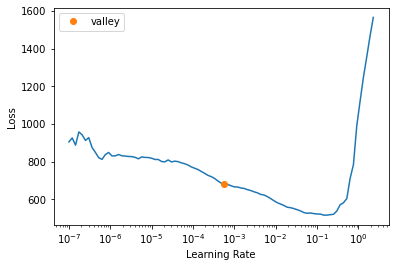

In [11]:
learn.lr_find()

In [12]:
learn.fit_one_cycle(5, lr_max = 3e-3)

epoch,train_loss,valid_loss,mae,time
0,193.122559,175.920944,10.277759,00:02
1,167.573303,154.983246,9.768171,00:02
2,145.840302,152.369019,9.681707,00:02
3,123.775955,149.929169,9.585099,00:02
4,116.041710,149.152817,9.569581,00:02


## Try XGBoost

In [13]:
X_train, Y_train = to.train.xs, to.train.ys.values.ravel()
X_val, Y_val = to.valid.xs, to.valid.ys.values.ravel()

In [14]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_log_error

In [15]:
my_model = XGBRegressor(colsample_bytree=0.4,
                        gamma = 0.,
                        learning_rate = 0.05,
                        max_depth = 5,
                        min_child_weight = 1.7,
                        n_estimators = 1000, 
                        reg_alpha = 0.5,
                        reg_lambda = 0.6,
                        subsample = 0.5,
                        seed = 42,
                        objective = 'reg:squarederror'
                       )
my_model.fit(X_train, Y_train, early_stopping_rounds = 5, eval_set = [(X_val,Y_val)], verbose = True)

[0]	validation_0-rmse:16.94524
[1]	validation_0-rmse:16.70983
[2]	validation_0-rmse:16.47326
[3]	validation_0-rmse:16.26125
[4]	validation_0-rmse:16.08836
[5]	validation_0-rmse:15.88815
[6]	validation_0-rmse:15.68370
[7]	validation_0-rmse:15.48815
[8]	validation_0-rmse:15.32399
[9]	validation_0-rmse:15.17445
[10]	validation_0-rmse:15.05358
[11]	validation_0-rmse:14.94318
[12]	validation_0-rmse:14.79126
[13]	validation_0-rmse:14.68347
[14]	validation_0-rmse:14.56917
[15]	validation_0-rmse:14.46573
[16]	validation_0-rmse:14.36846
[17]	validation_0-rmse:14.26923
[18]	validation_0-rmse:14.19197
[19]	validation_0-rmse:14.10589
[20]	validation_0-rmse:14.03661
[21]	validation_0-rmse:13.96829
[22]	validation_0-rmse:13.90238
[23]	validation_0-rmse:13.83859
[24]	validation_0-rmse:13.79485
[25]	validation_0-rmse:13.74154
[26]	validation_0-rmse:13.68931
[27]	validation_0-rmse:13.65013
[28]	validation_0-rmse:13.60273
[29]	validation_0-rmse:13.55692
[30]	validation_0-rmse:13.51820
[31]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=1.7, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=12, num_parallel_tree=1, random_state=42,
             reg_alpha=0.5, reg_lambda=0.6, scale_pos_weight=1, seed=42,
             subsample=0.5, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [16]:
preds = my_model.predict(X_val.values)
Y_val

/home/karrrrrrrr/miniconda3/envs/fastai2/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


array([ -4,   7,  34, ..., -34,  16,  10], dtype=int8)

In [17]:
mean_absolute_error(Y_val, preds)

9.77734